# Map 8 - Folds, fault and unconformity

This is the most complicated map. It is from Bennison et al. (2011). It contains folds, faults, and an unconformity. First, we import the required libraries.

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

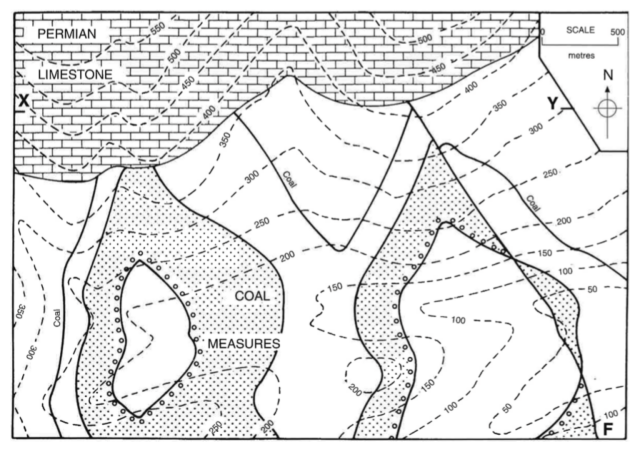

In [2]:
# Display map image
img = mpimg.imread("map8.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read topographic contours
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,4019.98,339.50,50,POINT (4019.98300 339.50000)
1,3951.29,334.53,50,POINT (3951.29100 334.53200)
2,3897.71,317.57,50,POINT (3897.70900 317.56800)
3,3841.43,306.20,50,POINT (3841.43200 306.19700)
4,3780.37,284.69,50,POINT (3780.36900 284.68900)


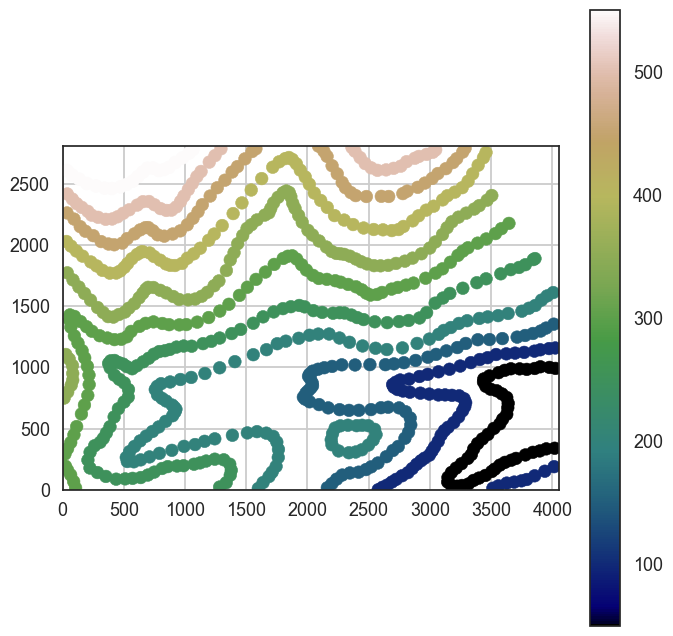

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True)
ax.set_ylim((0,2807))
ax.set_xlim((0,4052))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contours to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

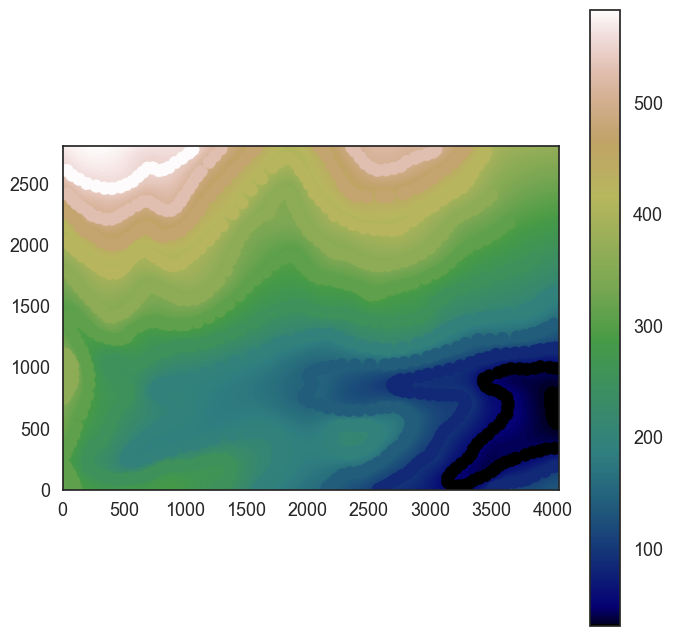

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth")
im = ax.imshow(topo_raster, origin="lower", extent=[0, 4052, 0, 2807], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map8.tif", 
                       extent=[0, 4052, 0, 2807], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open DEM from tif file
topo_raster = rasterio.open("dem_map8.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read points on contacts
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,2613.00,2205.99,F,POINT (2612.99600 2205.99400)
1,2697.93,2092.82,F,POINT (2697.93500 2092.82100)
2,2800.90,1935.71,F,POINT (2800.89900 1935.71200)
3,2901.72,1752.02,F,POINT (2901.71700 1752.01500)
4,3062.76,1507.51,F,POINT (3062.75600 1507.51000)


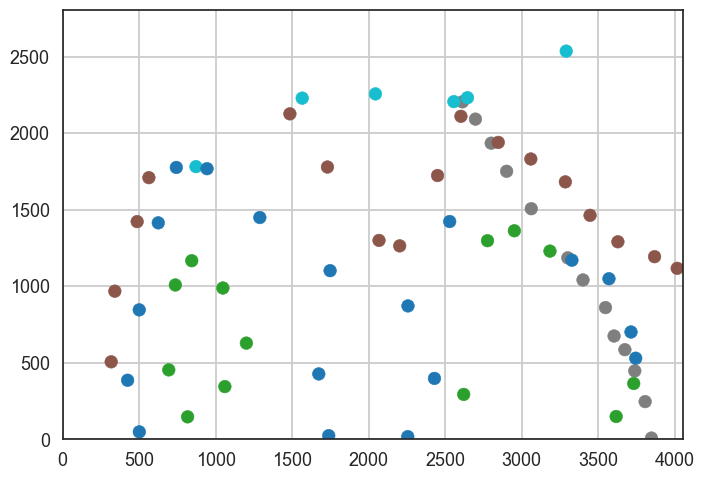

In [11]:
# Plot points at the contacts
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(8, 8))
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,2807))
ax.set_xlim((0,4052))
ax.grid();

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,2613.00,2205.99,F,POINT (2612.99600 2205.99400),413.18
1,2697.93,2092.82,F,POINT (2697.93500 2092.82100),396.84
2,2800.90,1935.71,F,POINT (2800.89900 1935.71200),365.38
3,2901.72,1752.02,F,POINT (2901.71700 1752.01500),313.27
4,3062.76,1507.51,F,POINT (3062.75600 1507.51000),247.19


### Strike lines

In [13]:
# Read strike lines
gdf = df_to_gdf(os.path.join("strike_lines", "strike_lines.txt"), sep="\t")
gdf.head()

,X,Y,Z,formation,id,geometry
0,63.61,1737.94,350,Permian Limestone,1,POINT (63.61200 1737.94000)
1,1866.90,2375.60,350,Permian Limestone,1,POINT (1866.90500 2375.59700)
2,2304.65,2187.76,400,Permian Limestone,2,POINT (2304.65400 2187.76000)
3,3342.51,2560.03,400,Permian Limestone,2,POINT (3342.51000 2560.03000)
4,692.42,250.74,200,B1,3,POINT (692.41800 250.74300)


In [14]:
# Convert points into strike lines
# Base of Permian limestone
linestring_gdf_PL = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "Permian Limestone"])
# Western fold, western flank, base of B
linestring_gdf_B1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B1"])
# Western fold, eastern flank, base of B
linestring_gdf_B2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B2"])
# Eastern fold, eastern flank, base of B
linestring_gdf_B3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B3"])
# Central fold, western flank, base of A
linestring_gdf_A1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "A1"])
# Central fold, eastern flank, base of A
linestring_gdf_A2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "A2"])
# Eastern fold, eastern flank, base of A
linestring_gdf_A3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "A3"])
# Fault
linestring_gdf_F = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "F"])
# Central fold, western flank, base of Coal
linestring_gdf_Coal1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "Coal1"])
# Central fold, eastern flank, base of Coal
linestring_gdf_Coal2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "Coal2"])
# Eastern fold,eastern flank, base of Coal
linestring_gdf_Coal3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "Coal3"])

In [15]:
# Check that the strike lines are correct
print("PL\n", linestring_gdf_PL.is_valid)
print("B1\n", linestring_gdf_B1.is_valid)
print("B2\n", linestring_gdf_B2.is_valid)
print("B3\n", linestring_gdf_B3.is_valid)
print("A1\n", linestring_gdf_A1.is_valid)
print("A2\n", linestring_gdf_A2.is_valid)
print("A3\n", linestring_gdf_A3.is_valid)
print("F\n", linestring_gdf_F.is_valid)
print("Coal1\n", linestring_gdf_Coal1.is_valid)
print("Coal2\n", linestring_gdf_Coal2.is_valid)
print("Coal3\n", linestring_gdf_Coal3.is_valid)

PL
 0    True
1    True
dtype: bool
B1
 0    True
1    True
dtype: bool
B2
 0    True
1    True
dtype: bool
B3
 0    True
1    True
dtype: bool
A1
 0    True
1    True
dtype: bool
A2
 0    True
1    True
dtype: bool
A3
 0    True
1    True
dtype: bool
F
 0    True
1    True
dtype: bool
Coal1
 0    True
1    True
2    True
dtype: bool
Coal2
 0    True
1    True
dtype: bool
Coal3
 0    True
1    True
dtype: bool


In [16]:
#Calculate orientations from strike lines
orientations_PL = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_PL)
orientations_B1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B1)
orientations_B2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B2)
orientations_B3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B3)
orientations_A1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A1)
orientations_A2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A2)
orientations_A3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A3)
orientations_F = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_F)
orientations_Coal1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal1)
orientations_Coal2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal2)
orientations_Coal3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal3)
# print orientations
print(f"PL dip = {orientations_PL.iloc[0,0]:.2f}, azimuth = {orientations_PL.iloc[0,1]:.2f}")
print(f"B1 dip = {orientations_B1.iloc[0,0]:.2f}, azimuth = {orientations_B1.iloc[0,1]:.2f}")
print(f"B2 dip = {orientations_B2.iloc[0,0]:.2f}, azimuth = {orientations_B2.iloc[0,1]:.2f}")
print(f"B3 dip = {orientations_B3.iloc[0,0]:.2f}, azimuth = {orientations_B3.iloc[0,1]:.2f}")
print(f"A1 dip = {orientations_A1.iloc[0,0]:.2f}, azimuth = {orientations_A1.iloc[0,1]:.2f}")
print(f"A2 dip = {orientations_A2.iloc[0,0]:.2f}, azimuth = {orientations_A2.iloc[0,1]:.2f}")
print(f"A3 dip = {orientations_A3.iloc[0,0]:.2f}, azimuth = {orientations_A3.iloc[0,1]:.2f}")
print(f"F dip = {orientations_F.iloc[0,0]:.2f}, azimuth = {orientations_F.iloc[0,1]:.2f}")
print(f"Coal1 dip = {orientations_Coal1.iloc[0,0]:.2f}, azimuth = {orientations_Coal1.iloc[0,1]:.2f}")
print(f"Coal2 dip = {orientations_Coal2.iloc[0,0]:.2f}, azimuth = {orientations_Coal2.iloc[0,1]:.2f}")
print(f"Coal3 dip = {orientations_Coal3.iloc[0,0]:.2f}, azimuth = {orientations_Coal3.iloc[0,1]:.2f}")

PL dip = 5.99, azimuth = 340.46
B1 dip = 26.33, azimuth = 270.28
B2 dip = 14.14, azimuth = 89.39
B3 dip = 15.12, azimuth = 89.99
A1 dip = 18.30, azimuth = 90.98
A2 dip = 19.39, azimuth = 270.06
A3 dip = 16.73, azimuth = 90.02
F dip = 51.11, azimuth = 64.74
Coal1 dip = 14.05, azimuth = 89.98
Coal2 dip = 24.64, azimuth = 269.95
Coal3 dip = 15.02, azimuth = 89.97


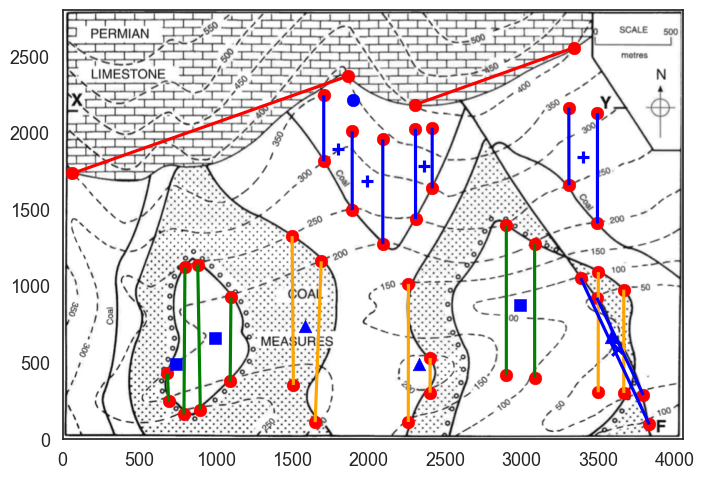

In [17]:
# Plot all this information to better understand the structure
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(img, extent=[0, 4052, 0, 2807], cmap="gray")   
# Plot points
gdf.plot(ax=ax, aspect="equal", color="red")
# Plot strike lines
# Base of Permian limestone
linestring_gdf_PL.plot(ax=ax, aspect="equal", color="red")
orientations_PL.plot(ax=ax, aspect="equal", color="blue", marker="o")
# Western fold, western flank, base of B
linestring_gdf_B1.plot(ax=ax, aspect="equal", color="green")
orientations_B1.plot(ax=ax, aspect="equal", color="blue", marker="s")
# Western fold, eastern flank, base of B
linestring_gdf_B2.plot(ax=ax, aspect="equal", color="green")
orientations_B2.plot(ax=ax, aspect="equal", color="blue", marker="s")
# Eastern fold, eastern flank, base of B
linestring_gdf_B3.plot(ax=ax, aspect="equal", color="green")
orientations_B3.plot(ax=ax, aspect="equal", color="blue", marker="s")
# Central fold, western flank, base of A
linestring_gdf_A1.plot(ax=ax, aspect="equal", color="orange")
orientations_A1.plot(ax=ax, aspect="equal", color="blue", marker="^")
# Central fold, eastern flank, base of A
linestring_gdf_A2.plot(ax=ax, aspect="equal", color="orange")
orientations_A2.plot(ax=ax, aspect="equal", color="blue", marker="^")
# Eastern fold, eastern flank, base of A
linestring_gdf_A3.plot(ax=ax, aspect="equal", color="orange")
orientations_A3.plot(ax=ax, aspect="equal", color="blue", marker="^")
# Fault
linestring_gdf_F.plot(ax=ax, aspect="equal", color="blue")
orientations_F.plot(ax=ax, aspect="equal", color="blue", marker="x")
# Central fold, western flank, base of Coal
linestring_gdf_Coal1.plot(ax=ax, aspect="equal", color="blue")
orientations_Coal1.plot(ax=ax, aspect="equal", color="blue", marker="+")
# Central fold, eastern flank, base of Coal
linestring_gdf_Coal2.plot(ax=ax, aspect="equal", color="blue")
orientations_Coal2.plot(ax=ax, aspect="equal", color="blue", marker="+")
# Eastern fold,eastern flank, base of Coal
linestring_gdf_Coal3.plot(ax=ax, aspect="equal", color="blue")
orientations_Coal3.plot(ax=ax, aspect="equal", color="blue", marker="+");

In [18]:
# Merge orientations
orientations = pd.concat([orientations_PL,orientations_F, orientations_B1, 
                          orientations_B2, orientations_B3, orientations_A1,
                          orientations_A2, orientations_A3, orientations_Coal1,
                          orientations_Coal2, orientations_Coal3]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.99,340.46,375.00,POINT (1894.42025 2215.33175),1.00,1894.42,2215.33,Permian Limestone
1,0,51.11,64.74,75.00,POINT (3626.42675 591.66350),1.00,3626.43,591.66,F
2,0,26.33,270.28,225.00,POINT (742.40525 492.85150),1.00,742.41,492.85,B1
3,0,14.14,89.39,225.00,POINT (994.39675 662.06325),1.00,994.40,662.06,B2
4,0,15.12,89.99,225.00,POINT (2992.26250 875.11500),1.00,2992.26,875.12,B3


In [19]:
# Rename orientations correctly
orientations["formation"] = ["Permian Limestone", "F", "B", "B", "B", "A","A","A","Coal","Coal","Coal","Coal"]
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.99,340.46,375.00,POINT (1894.42025 2215.33175),1.00,1894.42,2215.33,Permian Limestone
1,0,51.11,64.74,75.00,POINT (3626.42675 591.66350),1.00,3626.43,591.66,F
2,0,26.33,270.28,225.00,POINT (742.40525 492.85150),1.00,742.41,492.85,B
3,0,14.14,89.39,225.00,POINT (994.39675 662.06325),1.00,994.40,662.06,B
4,0,15.12,89.99,225.00,POINT (2992.26250 875.11500),1.00,2992.26,875.12,B


## 3. Construction of the model in GemPy

In [20]:
# Create a geomodel object called model8
geo_model = gp.create_model("model8")

In [21]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 4052, 0, 2807, 0, 600], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [22]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,F,Default series,1,#015482,1
1,Permian Limestone,Default series,2,#9f0052,2
2,Coal,Default series,3,#ffbe00,3
3,A,Default series,4,#728f02,4
4,B,Default series,5,#443988,5


In [23]:
# The base of the unit at the cores of the anticlines does not outcrop
# This is our "basement". Add this unit manually
geo_model.add_surfaces("C")

# Group units into series
gp.map_stack_to_surfaces(geo_model,
                         {"Fault": ("F"),"Strata1": ("Permian Limestone"),
                          "Strata2": ("Coal","A", "B","C"),},
                         remove_unused_series=True)

# Tell GemPy there is a fault
geo_model.set_is_fault(["Fault"])

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault,1,Fault,True,True,False
Strata1,2,Erosion,True,False,False
Strata2,3,Erosion,True,False,False


In [24]:
# Check the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,F,Fault,1,False,True,True,True,#527682,NaN,NaN,NaN,1,13,1
1,Permian Limestone,Strata1,1,False,False,True,True,#9f0052,NaN,NaN,NaN,2,6,1
2,Coal,Strata2,1,False,False,True,True,#ffbe00,NaN,NaN,NaN,3,17,4
3,A,Strata2,2,False,False,True,True,#728f02,NaN,NaN,NaN,4,18,3
4,B,Strata2,3,False,False,True,True,#443988,NaN,NaN,NaN,5,13,3
5,C,Strata2,4,True,False,True,True,#ff3f20,NaN,NaN,NaN,6,0,0


In [25]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map8.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [26]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [27]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True,
                    theano_optimizer="fast_compile");                    

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              4965.68
$C_o$            587094.12
drift equations  [3, 3, 3]


In [28]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

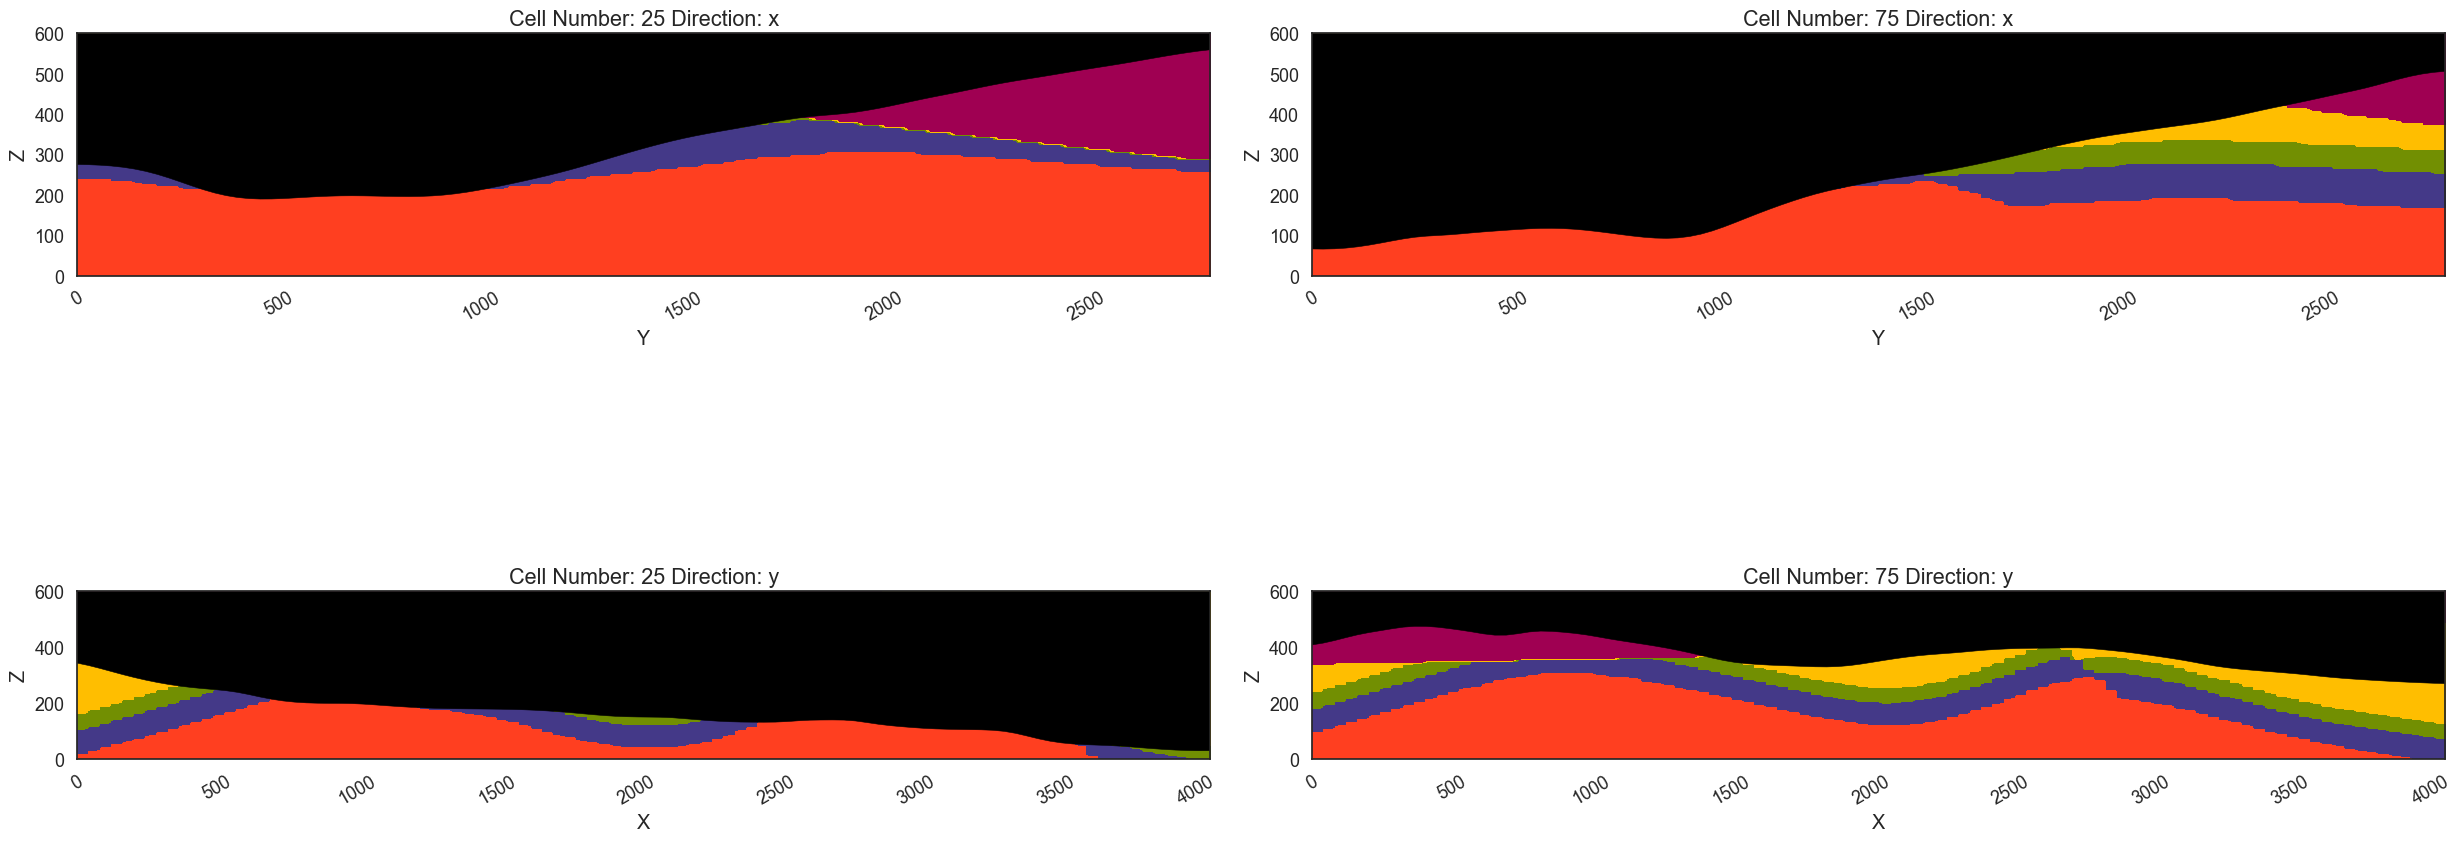

In [29]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [30]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);